In [1]:
# Flux at spacecraft:
import numpy as np
import pickle
from build_database import flux_obj
from scipy import interpolate
from matplotlib import pyplot as plt
from GLD_file_tools import GLD_file_tools
from satellite import Satellite
import datetime
import ephem
from coordinate_structure import coordinate_structure
from coordinate_structure import transform_coords
from longitude_scaling import longitude_scaling
from ionoAbsorp import ionoAbsorp
import os
from mpl_toolkits.basemap import Basemap
from precip_model import precip_model
import itertools
from measurement_model import measurement_model
import random

%matplotlib inline

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

/Users/austin/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def time_bin(time_bins, time, lon):
    '''Coarsely bin into a local time of day, with the idea that
        lightning has some hourly time dependence (i.e., rarely lightning in the morning)
    '''
#    time_bins = np.linspace(0,23,4)  # Vector of times to quantize to
    d = lon*24/360                   # Hour shift in longitude    

    # Local time, in fractional hours
    LT = time.hour + np.sign(d)*time.minute/60.0 + d
    
    # Did we loop around a day?
    if LT < 0:
        LT += 24
    if LT >= 24:
        LT -= 24

    # Quantize, return
    return find_idx_nearest_val(time_bins, LT)
    
#time_bins = np.linspace(0,24,4) - 4
#print time_bins

#print [time_bin(cur_time,l) for l in np.linspace(-180,180,10)]

def find_idx_nearest_val(array, value):
    '''Returns the index of the value in the array closest to the given value. For variable quantization!'''
    idx_sorted = np.argsort(array)
    sorted_array = np.array(array[idx_sorted])
    idx = np.searchsorted(sorted_array, value, side="left")
    if idx >= len(array):
        idx_nearest = idx_sorted[len(array)-1]
        return idx_nearest
    elif idx == 0:
        idx_nearest = idx_sorted[0]
        return idx_nearest
    else:
        if abs(value - sorted_array[idx-1]) < abs(value - sorted_array[idx]):
            idx_nearest = idx_sorted[idx-1]
            return idx_nearest
        else:
            idx_nearest = idx_sorted[idx]
            return idx_nearest

# arr = np.linspace(1,10,5)
# print arr

# print find_idx_nearest_val(arr, 7.78)

In [3]:
    GLD_root  = 'alex/array/home/Vaisala/feed_data/GLD'
    NLDN_root = 'alex/array/home/Vaisala/feed_data/NLDN'

    sat_TLE  = ["1 40378U 15003C   15293.75287141  .00010129  00000-0  48835-3 0  9990",
                "2 40378  99.1043 350.5299 0153633 201.4233 158.0516 15.09095095 39471"]

    # Satellite object:
    sat = Satellite(sat_TLE[0], sat_TLE[1],'Firebird 4')

    # Measurement object:
    f = measurement_model(database = "database_multiple.pkl", multiple_bands = False)

    # ---- Do The Thing:
    inTime = "2015-11-01T00:45:00"
    plottime = datetime.datetime.strptime(inTime,  "%Y-%m-%dT%H:%M:%S")

    sat.compute(plottime)
    sat.coords.transform_to('geomagnetic')

#     # bands is a list of energy bands to sample at (depending on database, 1 thru 8)
#     print "From banded measurement (all on):"
#     print f.get_measurement(plottime, sat.coords, mode='banded',bands=f.m.E_bands)
#     print "From single measurement:"
#     print f.get_measurement(plottime, sat.coords, mode='continuous',bands=f.m.E_bands)

(91, 181, 1)
2015-11-01 00:00:30
Starting run from  2015-11-01T00:00:00
[[-60.053489691834216, -148.78594769039327, datetime.datetime(2015, 11, 1, 0, 0), 0], -0.0001]
[[-61.958735758548805, -149.36464052863022, datetime.datetime(2015, 11, 1, 0, 0, 30), 0], 0.063536140995133564]
[[-63.860267919063602, -150.00496414933809, datetime.datetime(2015, 11, 1, 0, 1), 0], 0.067816285396264123]
[[-65.757652446549216, -150.72117101319262, datetime.datetime(2015, 11, 1, 0, 1, 30), 0], 0.00019225470050411212]
[[-67.650331553129192, -151.53228746649467, datetime.datetime(2015, 11, 1, 0, 2), 0], -2.5988732406619506e-05]
[[-69.537552296617818, -152.46422767390064, datetime.datetime(2015, 11, 1, 0, 2, 30), 0], -8.109833172759376e-05]
[[-71.418252689575695, -153.55317797248648, datetime.datetime(2015, 11, 1, 0, 3), 0], -0.0001]
[[-73.290913452313433, -154.85113570684643, datetime.datetime(2015, 11, 1, 0, 3, 30), 0], -0.0001]
[[-75.153268859782713, -156.43558978335452, datetime.datetime(2015, 11, 1, 0, 4)

KeyboardInterrupt: 

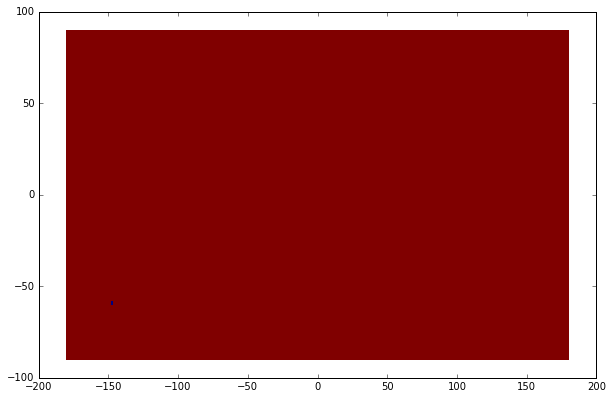

In [14]:
# State space: (Lat, Lon, Local Time, Sampling Mode)

gLats  = np.linspace(-90,90,91)
gLons  = np.linspace(-180,180,181)
gTimes = np.linspace(0,23,4)
gActs  = ['off', 'continuous']

# def lat_index(lat):
#     offset = 89
#     return int(np.round(lat) + offset)

# def lon_index(lon):
#     offset = 179
#     return int(np.round(lon) + offset)



storage_penalty = 1e-4 #1e-6  # Penalty for taking data (tunable)
alpha = 0.9
gamma = 0.1

# Simplest case -- learn a policy given lat, lon only:
Q = np.zeros([np.size(gLats), np.size(gLons), len(gActs)])
print np.shape(Q)

tStep = datetime.timedelta(seconds=30)


start_time = "2015-11-01T00:00:00"
cur_time = datetime.datetime.strptime(start_time,"%Y-%m-%dT%H:%M:%S")
print cur_time + tStep

sat.compute(cur_time)
geo_lon = sat.coords.lon()
sat.coords.transform_to('geomagnetic')

# Start a file to periodically dump entries to:
odb = dict()
odb['lats']    = gLats
odb['lons']    = gLons
odb['times']   = gTimes
odb['actions'] = gActs

with open('odb.pkl','wb') as file:
    pickle.dump(odb, file)


reward_table = []

print "Starting run from ", start_time
for i in range(1000):


    # select an action
    action = random.choice(gActs)
    
    #print action

    # take a measurement
    if action =='off':
        reward = 0
    else:
        meas = f.get_measurement(cur_time, sat.coords, mode=action)
        reward = meas*1e4 - storage_penalty*(action not in ['off'])
    #print reward
    #print sat.coords.lat(), sat.coords.lon()


    #cur_state = [np.int(np.round(sat.coords.lat())), np.int(np.round(sat.coords.lon())), gActs.index(action)]
    cur_ind = [find_idx_nearest_val(gLats,sat.coords.lat())[0],
                 find_idx_nearest_val(gLons,sat.coords.lon())[0],
                 time_bin(gTimes, cur_time, geo_lon),
                 gActs.index(action)]
    #print cur_ind[2]
    
#    cur_ind = [lat_index(sat.coords.lat()), lon_index(sat.coords.lon()), gActs.index(action)]
    
    #print cur_state
    #print cur_ind
#     print lat_index(sat.coords.lat())
#     print lon_index(sat.coords.lon())
    cur_state_continuous = [sat.coords.lat()[0], sat.coords.lon()[0], cur_time,  gActs.index(action)]
    
    #print cur_state
    
    # increment timestep:
    cur_time += tStep
    
    # Update satellite position for t+1:
    sat.compute(cur_time)
    geo_lon = sat.coords.lon()  # Save geographic longitude for time binning on the next iteration
    sat.coords.transform_to('geomagnetic')
    Qmax = np.max(Q[np.int(sat.coords.lat()), int(sat.coords.lon()), :], 0)
    Qcur = Q[cur_ind[0], cur_ind[1], cur_ind[3]]
    #print Qcur
    # update Q    
    Q[cur_ind[0], cur_ind[1], cur_ind[3]] += alpha*(reward + gamma*Qmax - Qcur)
    
    
    # Store the current state, action, and reward
    cv = [cur_state_continuous, reward]
    print cv
    reward_table.append(cv)
    
    if np.mod(i,100) == 0:
        with open('odb.pkl','wb') as file:
            pickle.dump(reward_table,file)
            reward_table = []

        plt.pcolor(gLons, gLats, Q[:,:,0])
    
    
    

In [ ]:
# # plt.pcolor(gLons, gLats, Q[:,:,0])
# print cur_state
# #print Q[[g-68, -152, 0]]
# #print -68 in gLats

# lat_dict = dict()
# for ind, val in enumerate(gLats):
#     lat_dict[int(val)] = ind
#     print val
# lon_dict = dict()
# for ind, val in enumerate(gLons):
#     lon_dict[val] = ind
# #    print ind

# print lat_dict[-89.1]

print cur_ind

IndexError: index 1 is out of bounds for axis 2 with size 1

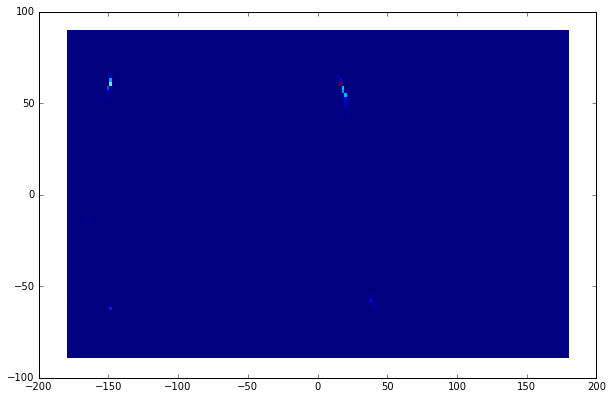

In [7]:
#print Q[cur_ind[0], cur_ind[1], cur_ind[2]]
for i in range(4):
    plt.pcolor(gLons, gLats, Q[:,:,i])

In [13]:
# with open('odb.pkl','wb') as file:
#     pickle.dump({1,2},file)
#     pickle.dump({3,4},file)
#     pickle.dump({5,6},file)
# with open('odb.pkl','rb') as file:
#     print pickle.load(file)
#     print pickle.load(file)
#     print pickle.load(file)
#     print pickle.load(file)


sat.coords.lon()[0]
sat.coords.lat()[0]
gLons
#     #cur_state = [np.int(np.round(sat.coords.lat())), np.int(np.round(sat.coords.lon())), gActs.index(action)]
# cur_ind = [find_idx_nearest_val(gLats,sat.coords.lat())[0],
#              find_idx_nearest_val(gLons,sat.coords.lon())[0],
#              time_bin(gTimes, cur_time, geo_lon),
#              gActs.index(action)]

    

array([-179.        , -176.99441341, -174.98882682, -172.98324022,
       -170.97765363, -168.97206704, -166.96648045, -164.96089385,
       -162.95530726, -160.94972067, -158.94413408, -156.93854749,
       -154.93296089, -152.9273743 , -150.92178771, -148.91620112,
       -146.91061453, -144.90502793, -142.89944134, -140.89385475,
       -138.88826816, -136.88268156, -134.87709497, -132.87150838,
       -130.86592179, -128.8603352 , -126.8547486 , -124.84916201,
       -122.84357542, -120.83798883, -118.83240223, -116.82681564,
       -114.82122905, -112.81564246, -110.81005587, -108.80446927,
       -106.79888268, -104.79329609, -102.7877095 , -100.78212291,
        -98.77653631,  -96.77094972,  -94.76536313,  -92.75977654,
        -90.75418994,  -88.74860335,  -86.74301676,  -84.73743017,
        -82.73184358,  -80.72625698,  -78.72067039,  -76.7150838 ,
        -74.70949721,  -72.70391061,  -70.69832402,  -68.69273743,
        -66.68715084,  -64.68156425,  -62.67597765,  -60.67039